In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict as dd
import matplotlib.pyplot as plt
import time
import networkx as nx
import freeman as fm

In [2]:
recipes = pd.read_csv("RAW_recipes.csv")
recipes.dropna(inplace=True)

In [3]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
interactions = pd.read_csv("RAW_interactions.csv")
interactions.dropna(inplace=True)

In [5]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
reviews = {} # {recipe_id: {nota:[total, quant], ingredientes:[]}}

for row in interactions.iterrows():
    recipe_id = row[1]["recipe_id"]
    rating = int(row[1]["rating"])
    if recipe_id not in reviews:
        reviews[recipe_id] = {}
        reviews[recipe_id]["nota"] = [0, 0]
        reviews[recipe_id]["ingredientes"] = []
    reviews[recipe_id]["nota"][0] += rating
    reviews[recipe_id]["nota"][1] += 1

In [18]:
ingredients_freq = dd(int)
ingredients_unique = dd(int)
for row in recipes.iterrows():
    ingred = eval(row[1]["ingredients"])
    recipe_id = row[1]["id"]
    if recipe_id in reviews:
        for i in range(len(ingred)):
            ingredients_unique[ingred[i]] += 1
            reviews[recipe_id]["ingredientes"].append(ingred[i])
            for j in range(i+1, len(ingred), 1):
                key = (ingred[i].replace("\"", ""), ingred[j].replace("\"", ""))
                key = tuple(sorted(key))
                ingredients_freq[key] += 1

In [19]:
tmp = {}
for key, i in ingredients_unique.items():
    if  i > 100 and i < 10000: # quantidade de receitas q o ingrediente tem q aparecer
        tmp[key.replace("\"", "")] = i

In [20]:
len(tmp)
# tmp

1778

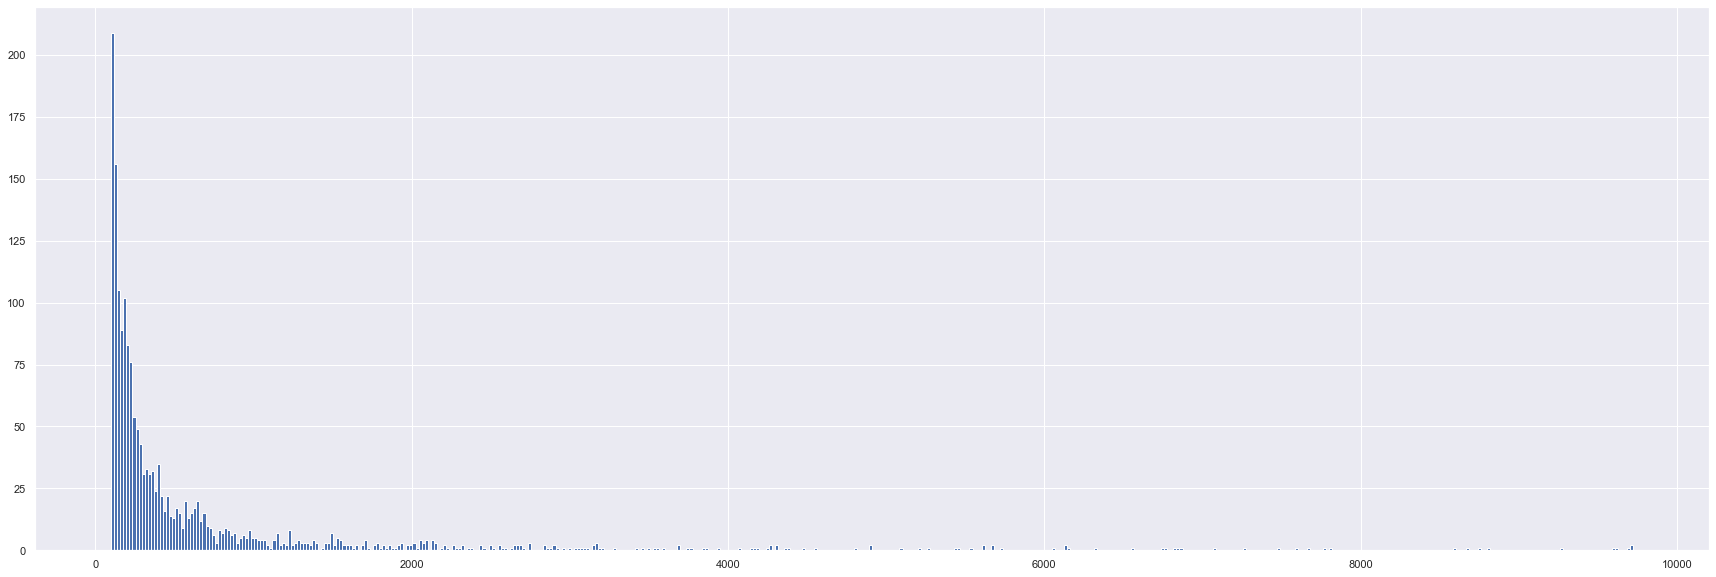

In [21]:
plt.figure(figsize=(30,10))
plt.hist(tmp.values(), bins=500);

In [22]:
ingredients_unique = tmp

In [23]:
tmp = set()
for key, i in ingredients_freq.items():
    if i > 100: # minimo de receitas que 2 ingredientes tem q aparecer pra existir edge
        tmp.add(key[0])
        tmp.add(key[1])


In [24]:
aa = {}
for key, i in ingredients_unique.items():
    if key in tmp:
        aa[key] = i


In [25]:
ingredients_unique = aa

In [26]:

t = time.time()
data = """graph [
    directed 0"""

tmp = {}
unique = set()
j = 0
edge = ""
for key, i in ingredients_freq.items():
    if i > 100: # minimo de receitas que 2 ingredientes tem q aparecer pra existir edge (mesmo numero eh usado mais acima)
        if key[0] in ingredients_unique and key[1] in ingredients_unique:
            unique.add(key[0])
            unique.add(key[1])
            tmp[key] = i
            edge += f"""
    edge [
        source "{key[0]}"
        target "{key[1]}"
        weight {i}
    ]"""
            j += 1

comp = ""
for i in unique:
    comp += f"""
    node [
        id "{i}"
        name "{i}"
    ]"""

data += comp

data += edge

data += "\n]\n"
t = time.time() - t
print(t)

0.18399810791015625


In [27]:
ingredients_freq = tmp

In [28]:
with open(f"ingredients.gml", "w") as f:
    f.write(data)

In [29]:
g = fm.load('ingredients.gml')

In [30]:
t = time.time()
g.set_all_nodes("size", 5)
g.set_all_nodes("labpos", "hover")
g.set_all_edges("color", (127, 127, 127))
g.label_nodes("name")

g.move("kamada_kawai")
g.draw()
t = time.time() - t

In [31]:
t

44.075379371643066

In [32]:
btw = nx.algorithms.centrality.betweenness_centrality(g)

In [33]:
t = {}
for key, i in btw.items():
    if i != 0:
        t[key] = i

In [34]:
(len(btw) - len(t)) / len(btw)

0.4294117647058823

In [35]:
util = {}

for recipe_id in reviews.keys():
    util[recipe_id] = {}
    s = 0
    i = 0
    for ingred in reviews[recipe_id]["ingredientes"]:
        if ingred in btw:
            s += btw[ingred]
            i += 1
    if i != 0:
        util[recipe_id]["mean_btw"] = s / i
    else:
        util[recipe_id]["mean_btw"] = 0
    util[recipe_id]["mean_note"] = reviews[recipe_id]["nota"][0] / reviews[recipe_id]["nota"][1]

        

In [36]:
util[159982]

{'mean_btw': 0.00023216936744433413, 'mean_note': 4.75}

In [37]:
recipes_df = pd.DataFrame(util).transpose()

In [38]:
recipes_df.head()

,mean_btw,mean_note
40893,0.016807,4.500000
44394,0.000000,4.000000
85009,0.016515,5.000000
120345,0.004468,2.000000
134728,0.020778,4.142857


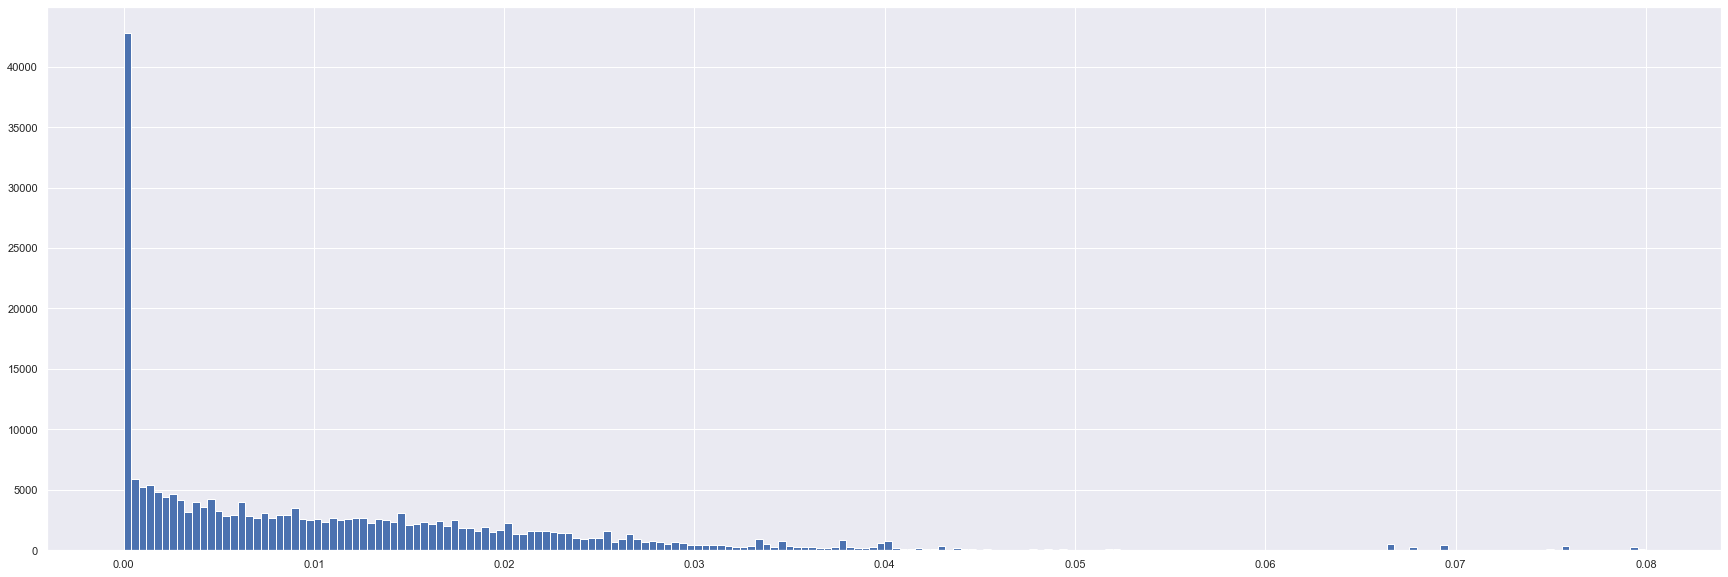

In [39]:
plt.figure(figsize=(30,10))
plt.hist(recipes_df["mean_btw"], bins=200);

In [40]:
recipes_df["mean_note"]

40893     4.500000
44394     4.000000
85009     5.000000
120345    2.000000
134728    4.142857
            ...   
470995    5.000000
241491    4.500000
257796    4.000000
72730     0.000000
386618    5.000000
Name: mean_note, Length: 231630, dtype: float64

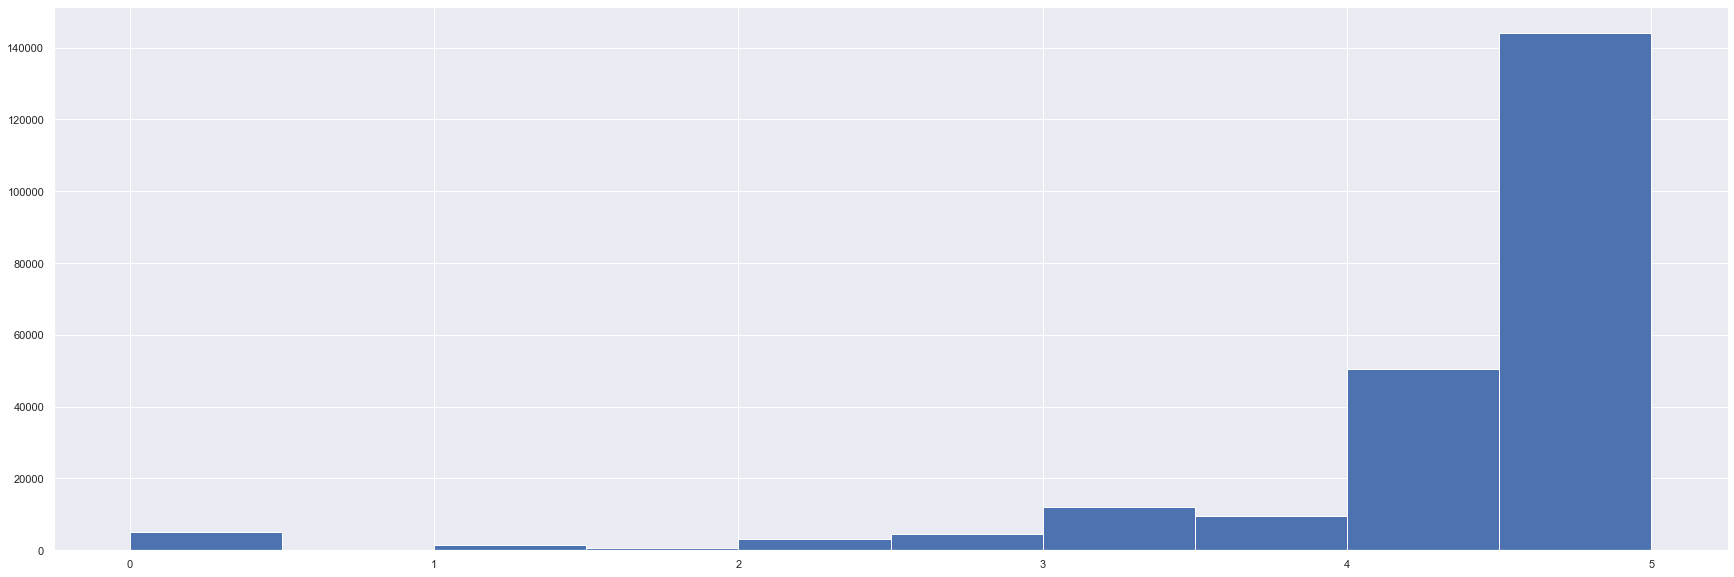

In [41]:
plt.figure(figsize=(30,10))
plt.hist(recipes_df["mean_note"], bins=10);

In [42]:
import statsmodels.api as sm
X_cp = sm.add_constant(recipes_df["mean_btw"])
model = sm.OLS(recipes_df["mean_note"], X_cp)
results = model.fit()

In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mean_note   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.27
Date:                Sat, 12 Jun 2021   Prob (F-statistic):           5.50e-05
Time:                        19:40:15   Log-Likelihood:            -3.2653e+05
No. Observations:              231630   AIC:                         6.531e+05
Df Residuals:                  231628   BIC:                         6.531e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3386      0.003   1550.421      0.000       4.333       4.344
mean_btw       0.6864      0.170      4.033      0.000       0.353       1.020
==============================================================================
Omnibus:                   118989.958   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           726800.128
Skew:                          -2.484   Prob(JB):                         0.00
Kurtosis:                      10.115   Cond. No.                         82.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""